In [4]:
import scipy.linalg as la

def flatten_tensor_list(tensors):
    flattened = []
    for tensor in tensors:
        # Changed view to reshape
        flattened.append(tensor.reshape(-1))
    return torch.cat(flattened, 0)

def get_eigen(H_bmm, matrix=None, maxIter=10, tol=1e-3, method='lanczos'):
    """
    compute the top eigenvalues of model parameters and
    the corresponding eigenvectors.
    """
    # change the model to evaluation mode, otherwise the batch Normalization Layer will change.
    # If you call this function during training, remember to change the mode back to training mode.
    params = None
    if params:
        q = flatten_tensor_list([torch.randn(p.size(), device=p.device) for p in params])
    else:
        q = torch.randn(matrix.size()[0])

    q = q / torch.norm(q)

    eigenvalue = None

    if method == 'power':
        # Power iteration
        for _ in range(maxIter):
            Hv = H_bmm(q)
            eigenvalue_tmp = torch.dot(Hv, q)
            Hv_norm = torch.norm(Hv)
            if Hv_norm == 0:
                break
            q = Hv / Hv_norm
            if eigenvalue is None:
                eigenvalue = eigenvalue_tmp
            else:
                if abs(eigenvalue - eigenvalue_tmp) / abs(eigenvalue) < tol:
                    return eigenvalue_tmp, q
                else:
                    eigenvalue = eigenvalue_tmp
        return eigenvalue, q

    elif method == 'lanczos':
        # Lanczos iteration
        b = 0
        if params:
            q_last = flatten_tensor_list([torch.zeros(p.size(), device=p.device) for p in params])
        else:
            q_last = torch.zeros(matrix.size()[0])
        q_s = [q_last]
        a_s = []
        b_s = []
        for _ in range(maxIter):
            Hv = H_bmm(q)
            a = torch.dot(Hv, q)
            Hv -= (b * q_last + a * q)
            q_last = q
            q_s.append(q_last)
            b = torch.norm(Hv)
            a_s.append(a)
            b_s.append(b)
            if b == 0:
                break
            q = Hv / b
        eigs, _ = la.eigh_tridiagonal(a_s, b_s[:-1])

        return eigs

In [83]:
import torch 
import numpy as np

mat = torch.randn((1000, 1000))
mat = mat.t() @ mat - 100 * torch.eye(mat.size()[0]) 
max_eigen = torch.max(torch.symeig(mat)[0])
errors_lan = []
errors_power = []
steps = [2**i for i in range(1, 8)]
for step in steps:
    errors_power.append(abs(max_eigen -
                            get_eigen(lambda x: mat @ x, matrix = mat,
                                  maxIter = step, method = 'power')[0]
                            )
                        )
    errors_lan.append(abs(max_eigen - 
                          get_eigen(lambda x: mat @ x, matrix = mat,
                                maxIter = step)
                          )
                      )

In [81]:
torch.randn((500, 500))

tensor([[ 0.07517819851636886597,  0.94186323881149291992,
         -0.56187140941619873047,  ...,
         -0.51976555585861206055, -0.29858949780464172363,
          0.92061364650726318359],
        [ 0.21380633115768432617,  0.25781142711639404297,
         -1.04383289813995361328,  ...,
         -0.04246550798416137695, -0.83615112304687500000,
         -0.00559923984110355377],
        [ 0.28588110208511352539,  1.50402879714965820312,
          1.70230901241302490234,  ...,
         -0.36408549547195434570,  0.73691231012344360352,
          0.75115054845809936523],
        ...,
        [-0.42751348018646240234, -1.76792895793914794922,
          0.13983084261417388916,  ...,
          0.61835551261901855469, -0.90039855241775512695,
          1.34479391574859619141],
        [ 0.47647881507873535156, -1.49410283565521240234,
          0.02938292734324932098,  ...,
          0.03575321659445762634, -0.32985588908195495605,
          1.41938126087188720703],
        [ 1.4314507246

In [68]:
torch.set_printoptions(precision=20)   

In [91]:
eigs_all = get_eigen(lambda x: mat @ x,
                     matrix = mat, maxIter=100)

In [87]:
eigs_all = get_eigen(lambda x: mat @ x - 3866.7346 * torch.eye(mat.size()[0]) @ x,
                     matrix = mat, maxIter=100)

In [92]:
eigs_all[-1]

3866.7344

In [88]:
eigs_all[0] + 3866.7346

-99.84547812500023

In [93]:
max(torch.symeig(mat)[0])

tensor(3866.72729492187500000000)

Text(0.5, 1.0, 'lanczos')

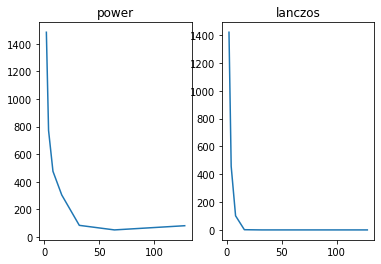

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.subplot(1, 2, 1)
plt.plot(steps, errors_power)
plt.title('power')

plt.subplot(1, 2, 2)
plt.plot(steps, errors_lan)
plt.title('lanczos')

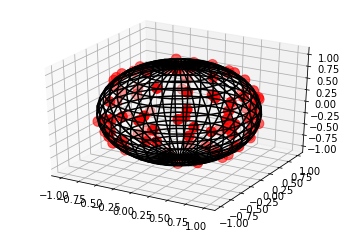

In [6]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

phi = torch.linspace(0, np.pi, 20)
theta = torch.linspace(0, 2 * np.pi, 40)
x = torch.ger(torch.sin(theta), torch.cos(phi))
y = torch.ger(torch.sin(theta), torch.sin(phi))
z = torch.ger(torch.cos(theta), torch.ones_like(phi))

xi, yi, zi = sample_spherical(100)

fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
ax.scatter(xi, yi, zi, s=100, c='r', zorder=10)
